# Clasificación 6 clases

## Librerias

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

## Generación de Datos

##### Grafico de la distribución de las clases

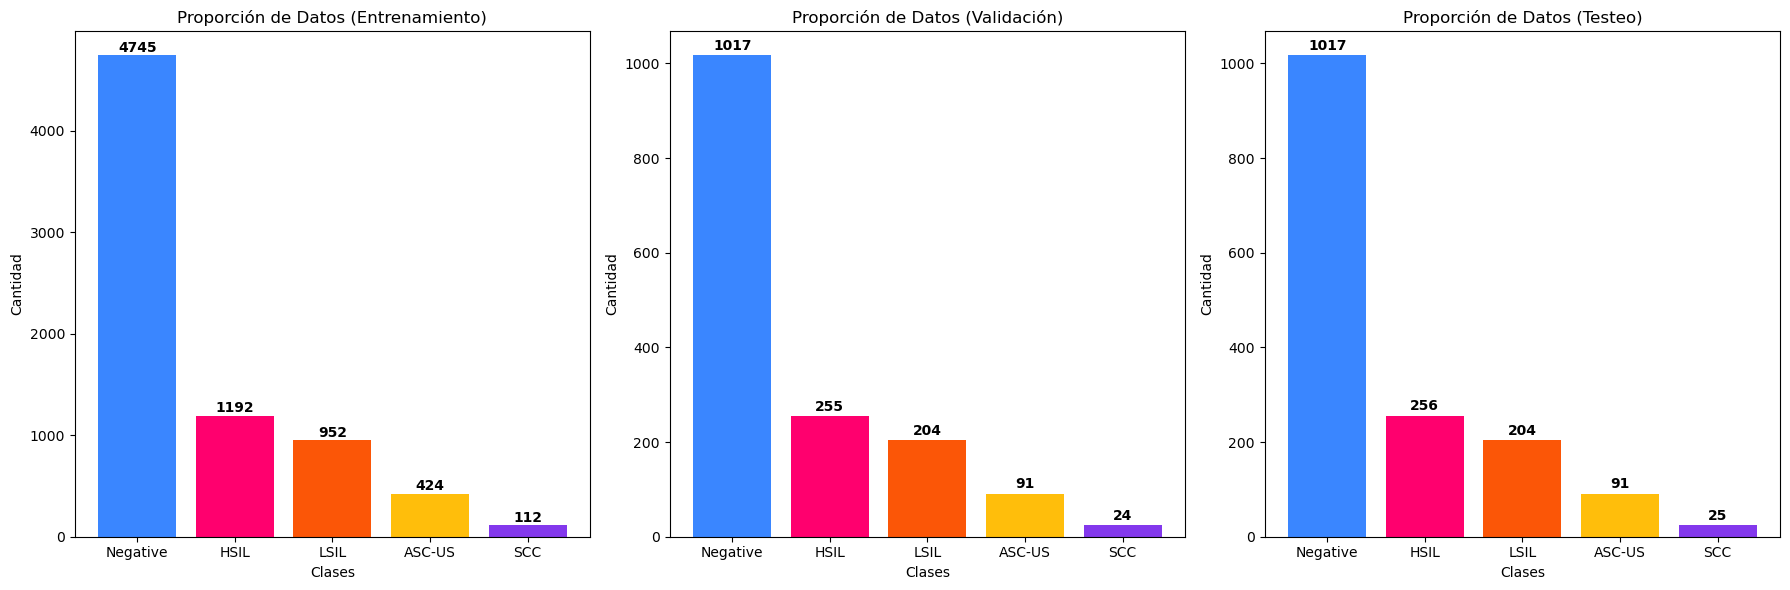

In [2]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Función para contar imágenes en cada clase dentro de la carpeta base
def count_images_in_folders(base_folder):
    class_counts = defaultdict(int)
    for class_name in os.listdir(base_folder):
        class_path = os.path.join(base_folder, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] += len(os.listdir(class_path))
    return dict(class_counts)

# Función para graficar las proporciones de las clases
def plot_class_proportion_subplot(ax, class_counts, title, order=None):
    if order:
        ordered_class_counts = {class_name: class_counts[class_name] for class_name in order if class_name in class_counts}
    else:
        ordered_class_counts = class_counts
    
    ax.bar(ordered_class_counts.keys(), ordered_class_counts.values(), color=['#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC', '#06D6A0'])
    ax.set_xlabel('Clases')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad sobre las barras
    for i, (class_name, count) in enumerate(ordered_class_counts.items()):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento y prueba
train_dir = 'crops_6classes/train/'
val_dir = 'crops_6classes/val'
test_dir = 'crops_6classes/test'

# Contar las imágenes en cada conjunto
train_class_counts = count_images_in_folders(train_dir)
val_class_counts = count_images_in_folders(val_dir)
test_class_counts = count_images_in_folders(test_dir)

# Orden deseado de las clases
class_order = ['Negative', 'HSIL', 'LSIL', 'AUS-US', 'ASC-US', 'SCC']

# Crear gráficos para los conjuntos de entrenamiento y prueba
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

# Gráficos
plot_class_proportion_subplot(axes[0], train_class_counts, 'Proporción de Datos (Entrenamiento)', order=class_order)
plot_class_proportion_subplot(axes[1], val_class_counts, 'Proporción de Datos (Validación)', order=class_order)
plot_class_proportion_subplot(axes[2], test_class_counts, 'Proporción de Datos (Testeo)', order=class_order)

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

#### Generadores

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del generador de aumentación para entrenamiento
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de imágenes para entrenamiento en modo multiclase
train_generator = train_datagen.flow_from_directory(
    'crops_6classes/train',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', 
    shuffle=True
)

# Generador de imágenes para validación en modo multiclase
val_generator = val_test_datagen.flow_from_directory(
    'crops_6classes/val',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generador de imágenes para prueba en modo multiclase
test_generator = val_test_datagen.flow_from_directory(
    'crops_6classes/test', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8072 images belonging to 6 classes.
Found 1730 images belonging to 6 classes.
Found 1732 images belonging to 6 classes.


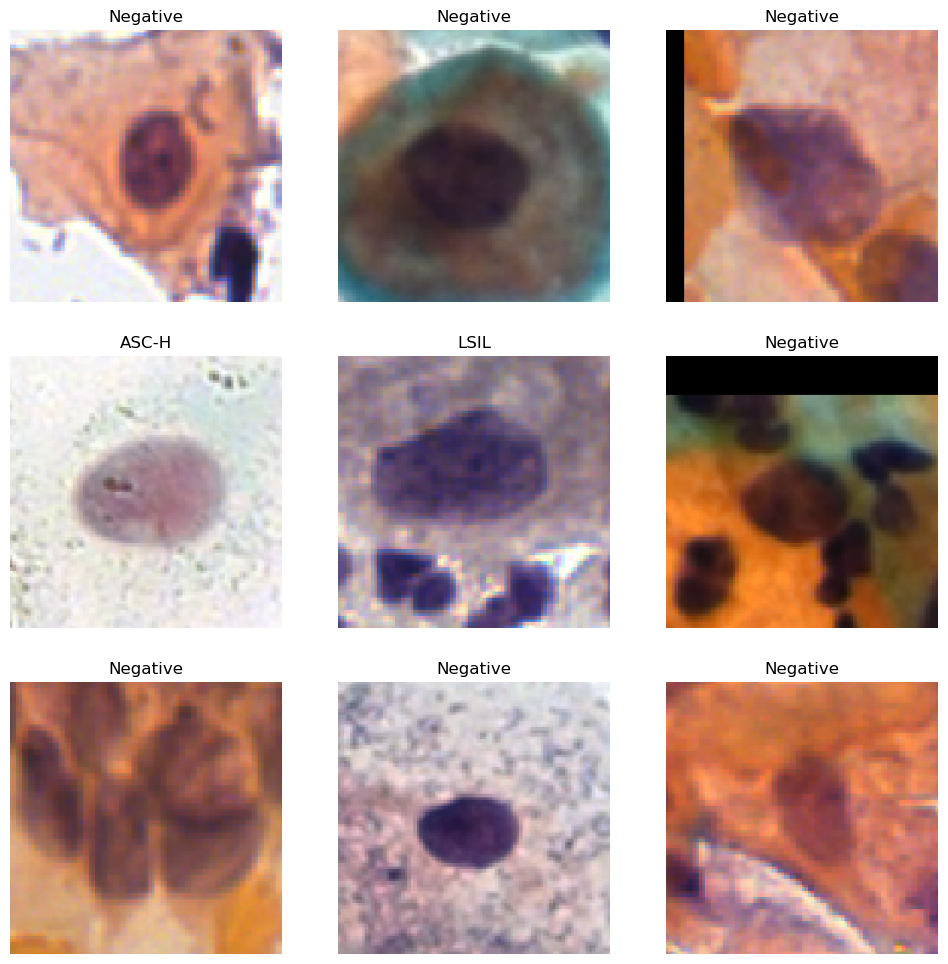

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un batch de imágenes y etiquetas
images, labels = next(train_generator)

# Obtener los nombres de las clases
class_labels = list(train_generator.class_indices.keys())

# Visualizar las primeras 9 imágenes del batch
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(class_labels[label_index])
    plt.axis("off")
plt.show()


## Modelos

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = train_generator.num_classes

# # Pesos de clase para manejar el desbalance
# class_weights = compute_class_weight(
#     # class_weight='balanced',
#     classes=np.unique(train_generator.classes),
#     y=train_generator.classes
# )
# class_weights = dict(enumerate(class_weights))

# Cargar el modelo base Xception preentrenado en ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Habilitamos el fine-tuning completo

# Congelar las primeras capas para evitar sobreajuste rápido
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Definir el modelo
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])  # ARREGLAR

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    # class_weight=class_weights,  # Aplicar los pesos de clase
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 653s 3s/step - accuracy: 0.6287 - auc: 0.8861 - f1_score: 0.8861 - loss: 1.0142 - precision: 0.8171 - recall: 0.4639 - val_accuracy: 0.7884 - val_auc: 0.9639 - val_f1_score: 0.9639 - val_loss: 0.5961 - val_precision: 0.8482 - val_recall: 0.7266 - learning_rate: 1.0000e-04
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 639s 3s/step - accuracy: 0.8457 - auc: 0.9832 - f1_score: 0.9832 - loss: 0.4160 - precision: 0.9044 - recall: 0.7880 - val_accuracy: 0.8139 - val_auc: 0.9641 - val_f1_score: 0.9641 - val_loss: 0.6071 - val_precision: 0.8395 - val_recall: 0.7890 - learning_rate: 1.0000e-04
Epoch 3/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9428 - auc: 0.9974 - f1_score: 0.9974 - loss: 0.1695 - precision: 0.9645 - recall: 0.9207
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
253/253 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.9428 - auc: 0.9974 - f1_score: 0.9974 - loss: 0.1695 - precision: 0.9645 - recall: 0.92

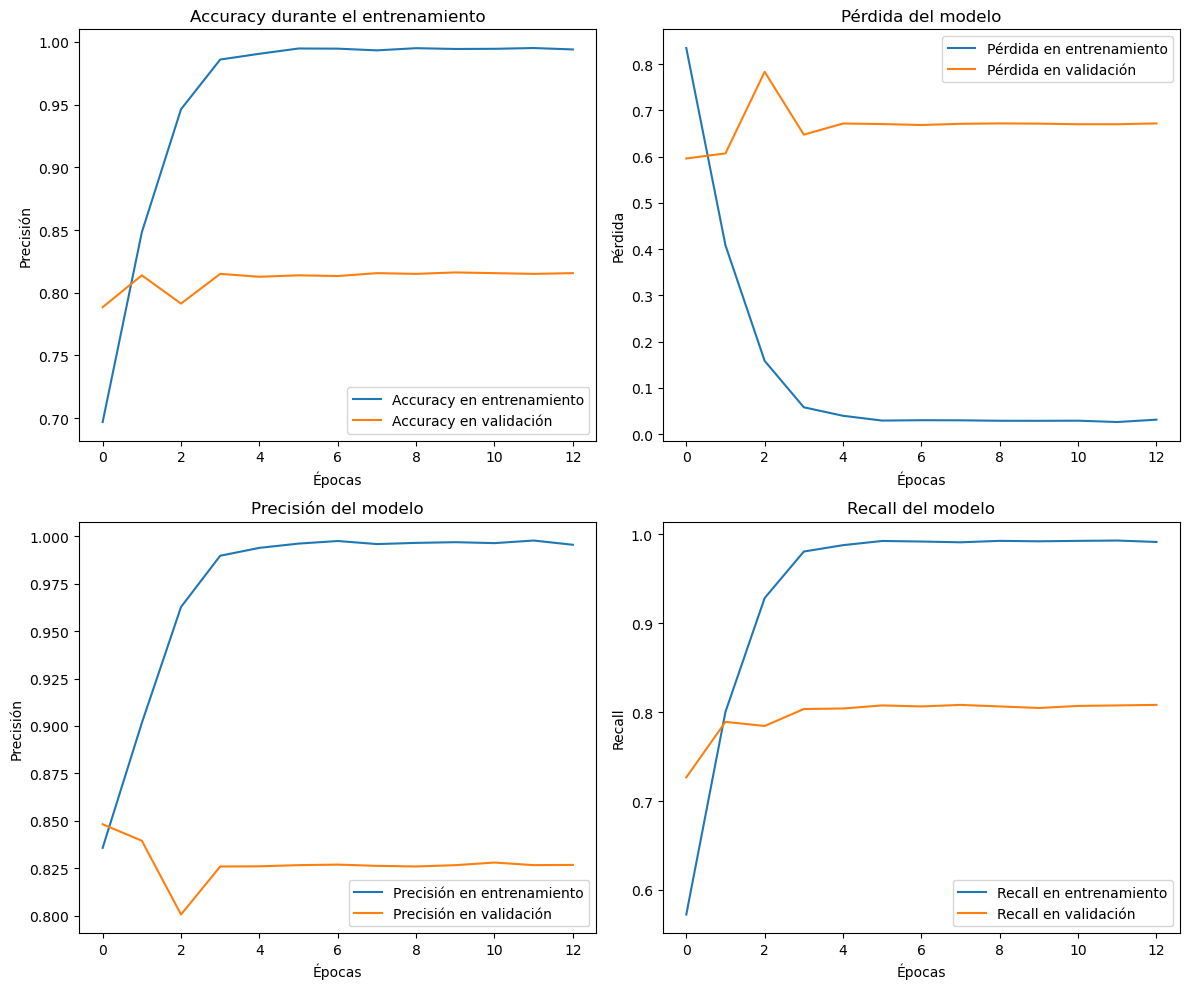

In [8]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

# /55 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7653 - auc: 0.9555 - f1_score: 0.9555 - loss: 0.7579 - precision: 0.7819 - recall: 0.7475
# Pérdida en el conjunto de prueba: 0.5629568099975586
# accuracy en el conjunto de prueba: 0.8140877485275269
# Precision en el conjunto de prueba: 0.8309352397918701
# Recall en el conjunto de prueba: 0.8002309203147888
# AUC en el conjunto de prueba: 0.9721276760101318
# F1-Score en el conjunto de prueba: 0.9721276760101318

55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 831ms/step - accuracy: 0.7239 - auc: 0.9290 - f1_score: 0.9290 - loss: 0.9789 - precision: 0.7384 - recall: 0.6990
Pérdida en el conjunto de prueba: 0.6174238920211792
accuracy en el conjunto de prueba: 0.8221709132194519
Precision en el conjunto de prueba: 0.837334930896759
Recall en el conjunto de prueba: 0.8054272532463074
AUC en el conjunto de prueba: 0.9651789665222168
F1-Score en el conjunto de prueba: 0.9651789665222168


55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 844ms/step


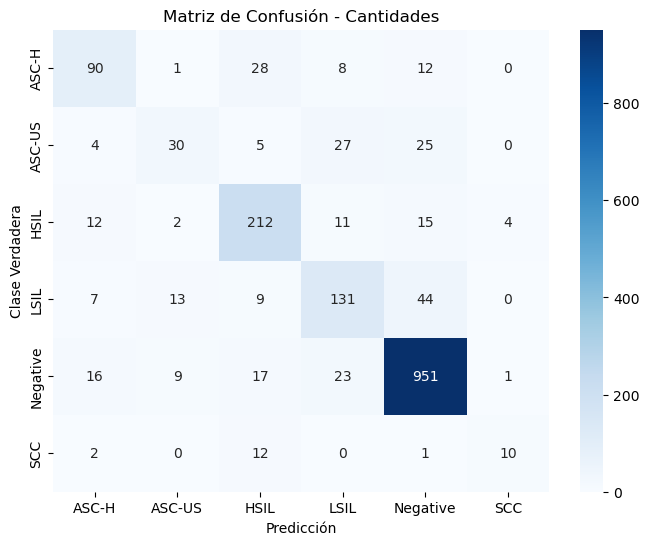

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 853ms/step


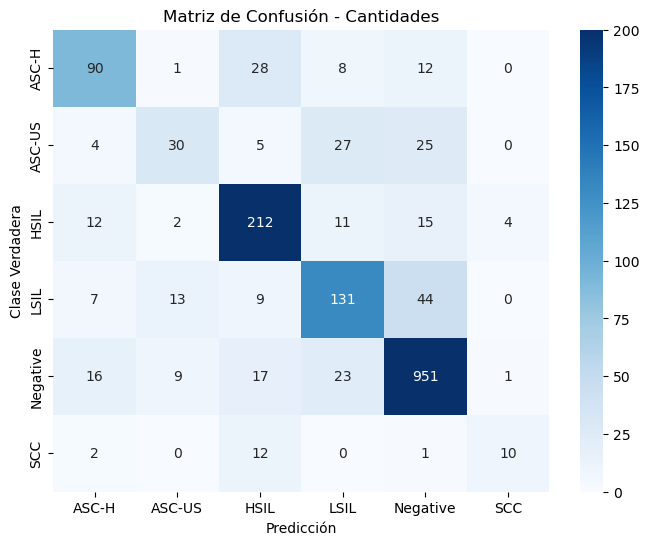

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión con escala limitada
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d', vmax=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels, vmax=vmax)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades y escala limitada
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades', vmax=200)

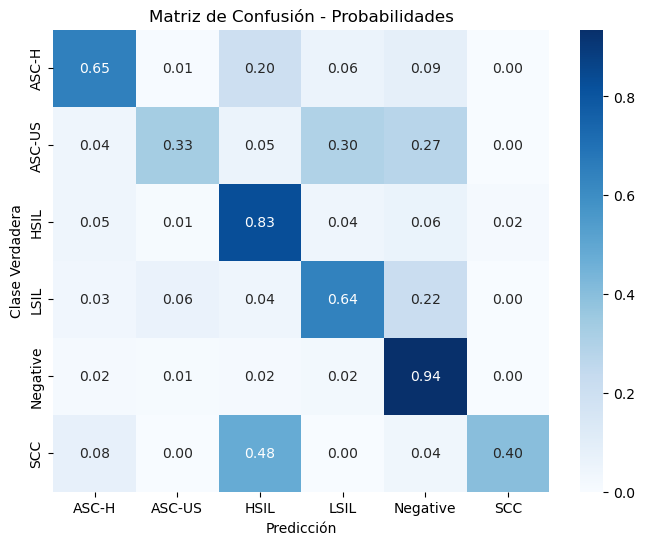

In [12]:
# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

In [13]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.69      0.65      0.67       139
      ASC-US       0.55      0.33      0.41        91
        HSIL       0.75      0.83      0.79       256
        LSIL       0.66      0.64      0.65       204
    Negative       0.91      0.94      0.92      1017
         SCC       0.67      0.40      0.50        25

    accuracy                           0.82      1732
   macro avg       0.70      0.63      0.66      1732
weighted avg       0.81      0.82      0.82      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 834ms/step


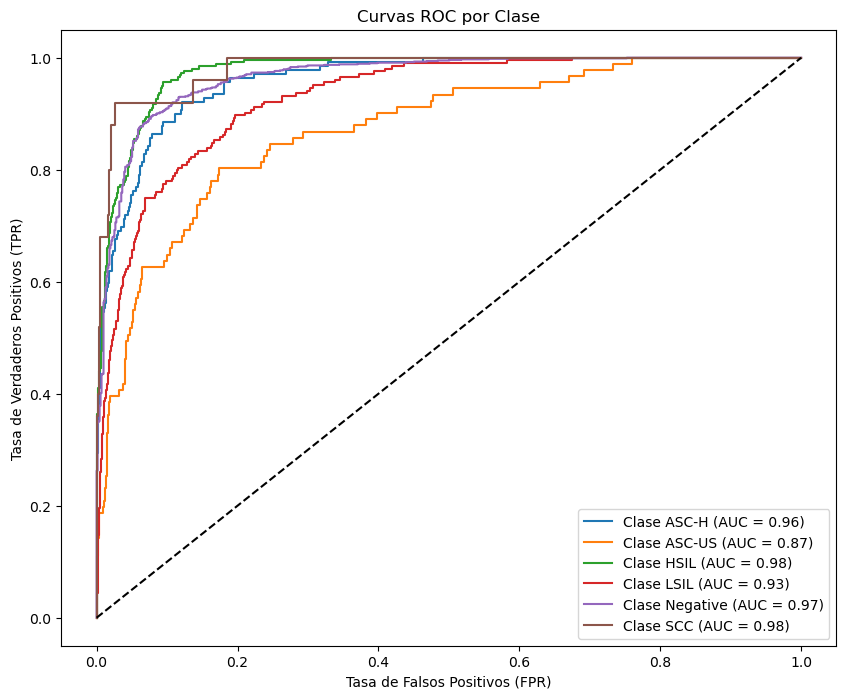

AUC Promedio: 0.95
AUC Promedio Ponderado: 0.96


In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')